In [80]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import ot
from ot.bregman import (barycenter, barycenter_debiased,
                        convolutional_barycenter2d,
                        convolutional_barycenter2d_debiased)
from tqdm.notebook import tqdm

import torch
from Barycenter_fixed import barycenter_debiased_1d

# 1. One dimensional case

In [81]:
n = 100  # nb bins

# bin positions
x = np.arange(n,)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=10, s=2.5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=90, s=2.5)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

In [82]:
print(A.shape)

(100, 2)


In [83]:
t = 0.5
weights = np.array([1-t,t])

epsilons = [0.01, 0.05, 0.1]

bars_debiased = [barycenter_debiased(A,M,reg,weights) for reg in epsilons]

In [84]:
bar_expected = ot.datasets.make_1D_gauss(n, m=50, s=2.5)

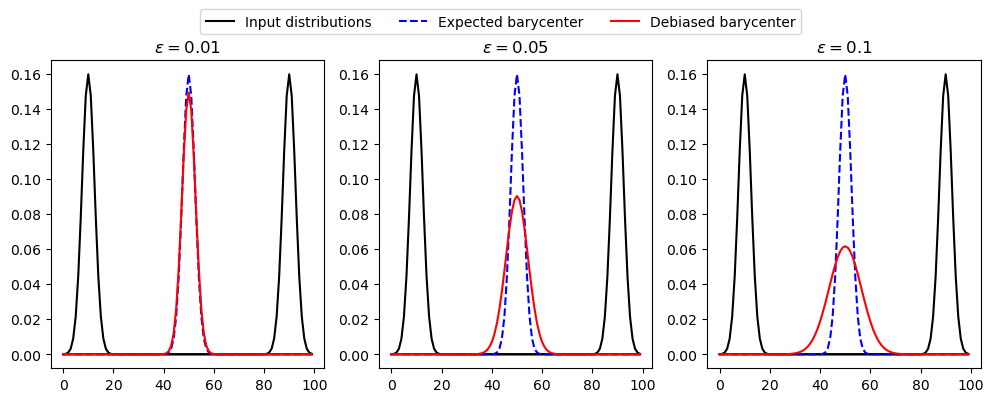

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# For collecting all the labels and handles
handles, labels = [], []

for i in range(len(epsilons)):
    axs[i].plot(x, a1, color='black', label='Input distributions')
    axs[i].plot(x, a2, color='black')
    axs[i].plot(x, bar_expected, color='blue', linestyle='dashed', label='Expected barycenter')
    axs[i].plot(x, bars_debiased[i], color='red', label='Debiased barycenter')
    
    # For the first subplot, collect the handles and labels
    if i == 0:
        h, l = axs[i].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))

# Add the legend above the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.025), ncol=len(labels))
plt.show()


# 2. Two dimensional space

In [86]:
n = 20

x = np.random.randint(n, size=1)
y = n - np.random.randint(n, size=1)

mu0 = np.zeros((n,n))
mu1 = np.zeros((n,n))

mu0[x,x] = 1
mu1[x,y] = 1

A = np.array([mu0,mu1])


In [87]:
t = 0.3
weights = np.array([1-t,t])
epsilons = [0.01,0.05,0.1]

bars_debiased = [convolutional_barycenter2d_debiased(A, reg, weights) for reg in epsilons]

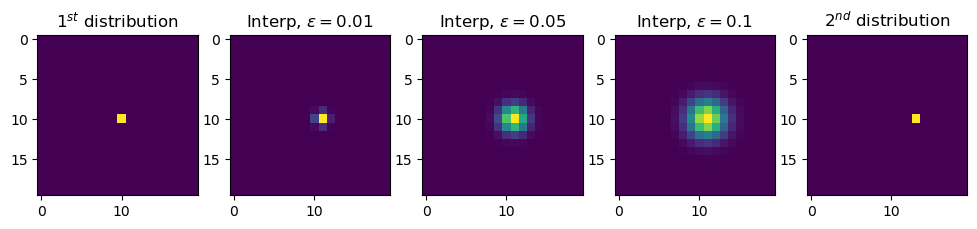

In [88]:
fig,axs = plt.subplots(1, len(epsilons)+2, figsize = (12,4))

axs[0].imshow(mu0)
axs[0].set_title(r'$1^{st}$ distribution')
for i,reg in enumerate(epsilons):
    axs[i+1].imshow(bars_debiased[i])
    axs[i+1].set_title(r'Interp, $\varepsilon = {}$'.format(epsilons[i]))
axs[-1].imshow(mu1)
axs[-1].set_title(r'$2^{nd}$ distribution')

plt.show()

# 3. Self-code algorithm debiased

In [89]:
import warnings

In [90]:
def self_barycenter_debiased(A, M, reg, weights=None, numItermax=1000, tol=1e-6):
    
    """
    Computing the Sinkhorn barycenter
    
    Args:
    - A
    - M
    - reg
    - weights:
    - numItermax
    - tol:
    
    Output:
    - bar
    """
    # INITIALIZATION  
    
    A = np.asarray(A) # list to array
    M = np.asarray(M) # list to array
    
    
    if weights is None:
        weights = np.ones((A.shape[1],)) / A.shape[1]
    else:
        assert (len(weights) == A.shape[1])
    
    K = np.exp(-M/reg) # define the kernel function K
    
    Ka = np.ones(A.shape)
    Kb = np.ones(A.shape)

    b = np.ones(A.shape)
    d = np.ones(A.shape[0]) # n,1
    bar = np.ones(A.shape[0])
    
    # COMPUTING THE BARYCENTER
    
    for it in range(numItermax):
        
        bar_old = bar
        a = A / Kb
        Ka = np.dot(K.T, a) #n x k
        bar = d*np.prod(Ka**weights[None,:], axis=1) # n x 1
        b = bar[:, None] / Ka
        Kb = np.dot(K,b)
        d = (d * bar / np.dot(K, d)) ** 0.5
        if np.linalg.norm(bar-bar_old) < tol  and it > 20:
            break
    return bar

## 3.1 First experiment

In [91]:
n = 100  # nb bins

# bin positions
x = np.arange(n,)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=10, s=2.5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=90, s=2.5)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

In [92]:
t = 0.5
weights = np.array([1-t,t])

epsilons = [0.01, 0.05, 0.1]

bars_debiased = [self_barycenter_debiased(A,M,reg,weights, numItermax=1000, tol=1e-4) for reg in epsilons]
Janati_debiased = [barycenter_debiased(A, M, reg, weights, numItermax=1000, stopThr=1e-4) for reg in epsilons]
# bar_expected = ot.datasets.make_1D_gauss(n, m=50, s=2.5)

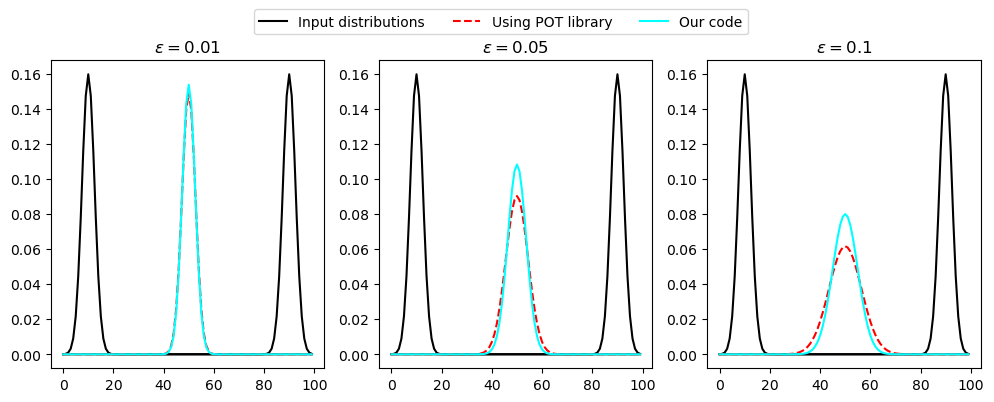

In [93]:
fig,axs = plt.subplots(1,3, figsize = (12,4))

# For collecting all the labels and handles
handles, labels = [], []

for i in range(len(epsilons)):
    axs[i].plot(x, a1, color='black', label='Input distributions')
    axs[i].plot(x, a2, color='black')
#     axs[i].plot(x, bar_expected, color = 'yellow', linestyle = 'dashed', label='Expected barycenter')
    axs[i].plot(x, Janati_debiased[i], color = 'red', linestyle = 'dashed', label="Using POT library")
    axs[i].plot(x, bars_debiased[i], color='cyan', label='Our code')
    
    # For the first subplot, collect the handles and labels
    if i == 0:
        h, l = axs[i].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))
    
# Add the legend above the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.025), ncol=len(labels))
plt.show()

## 3.2 Second experiment

In [94]:
def gen1D_gaussian(x, m, s):
    p = (1/(np.sqrt(2*np.pi*s**2))) * np.exp(-(x-m)**2 / (2*s**2))
    return p

In [95]:
n_features = 1000


m1 = -3
s1 = 0.4
m2 = 3
s2 = 0.4

grid = np.linspace(-5,5,n_features)


# Gaussian distributions
p1 = gen1D_gaussian(grid, m1, s1)  # m= mean, s= std
p2 = gen1D_gaussian(grid, m2, s2)


# creating matrix A containing all distributions
P = np.vstack((p1, p2)).T
n_distributions = P.shape[1]

# loss matrix + normalization
M = (grid[:, None] - grid[None, :])**2
# M = M / M.max()

In [96]:
t = 0.5
weights = np.array([1-t,t])
epsilons = np.array([50, 100, 250]) / n_features

bars_debiased = []
Janatis_debiased = []
for reg in epsilons:
    bar_debiased = self_barycenter_debiased(P, M, reg, weights, numItermax=5000, tol=1e-5)
    bars_debiased.append(bar_debiased)
#     list_K.append(K)
    
    Janati_debiased = barycenter_debiased(P, M, reg, weights, numItermax=5000, stopThr=1e-5)
    Janatis_debiased.append(Janati_debiased)

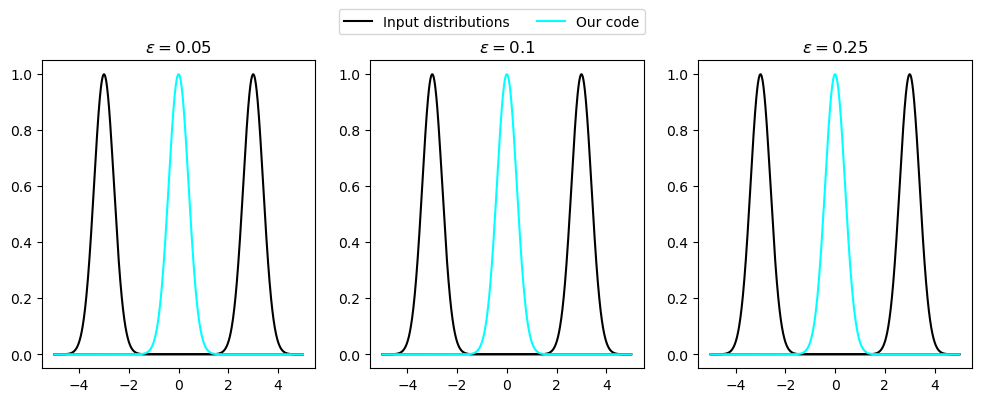

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# For collecting all the labels and handles
handles, labels = [], []

for i in range(len(epsilons)):
    axs[i].plot(grid, p1, color='black', label='Input distributions')
    axs[i].plot(grid, p2, color='black')
    # axs[i].plot(grid, Janatis_debiased[i], color = 'red', linestyle = 'dashed', label="Using POT library")
    axs[i].plot(grid, bars_debiased[i], color='cyan', label='Our code')
    
    # For the first subplot, collect the handles and labels
    if i == 0:
        h, l = axs[i].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    axs[i].set_title(r'$\varepsilon= {}$'.format(epsilons[i]))

# Add the legend above the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.025), ncol=len(labels))
plt.show()

In [98]:
q = barycenter_debiased_1d(P, M, reg, maxiter=5000, tol=1e-5, weights=None)

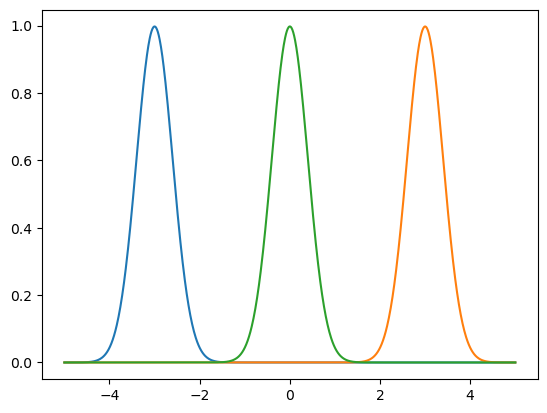

In [99]:
plt.plot(grid,p1)
plt.plot(grid,p2)
plt.plot(grid,q)

In [100]:
imgs = torch.tensor([[[[1.0, 2.0],
                       [3.0, 4.0]]]])

print(imgs.shape)

torch.Size([1, 1, 2, 2])


In [101]:
np.array([[1,2],[3,4]]).shape

(2, 2)